In [1]:
#Written by Andrew Hamilton, TLU Physics, Class of 2019
#Part of a research project done in collaboration with Dr. Josh Fuchs during the Summer of 2018 through the Spring of 2019

**Changelog: 1/30/2019**

•7/9 Problem fully resolved by selectively utilizing magnitudes present in given data, rather than in LARP tables, which contain all data

•xmm_processor has been created to address the col0 & col21 issues, as well as covering the conversion of the dataset's coordinates from arcminutes to degrees. This acts mostly as a bandaid solution to minor incompatabilities between the XMM data and this algorithm

•not sure if this was impossible before, but individual data tables can be scanned by the algorithm, so one can plug in an SDSS, WISE, or XMM table individually and be given a result. SDSS is the only one that has tight-enough characteristics to produce filters within 1 stdev tho :(

**Changelog: 2/27/2019**

•sdss_processor has been created to mildly reshape sdss data to play nicely with XMM data (if needed)

•"verbose" argument added to index_filterator to control if it prints out _every single filter_ or not

•full implementation of merged data tables using the companion program "Query Generators.ipynb"!!!!!!!!

**Changelog: **

In [2]:
import numpy as np
import csv
from astropy.table import Table, vstack, hstack, join
from astropy.io import ascii

# Functions

## •Organizing Data

In [3]:
def super_tableizer(data):
    """Super Tableizer
    
    Will combine given tables of astro data (as long as the first 2 columns are ra and dec), into one large table
    
    Args:
        Data (list): List containing data tables that you want to combine together
        
    Return:
        (Astropy.Table): Combined Table
    """
    count = 0
    datatable = Table()
    for dataset in data:
        if count == 0:
            for name in dataset.colnames:
                datatable[name] = dataset[name]
        else:
            for name in dataset.colnames[2:]:
                datatable[name] = dataset[name]
        count += 1
                
    return datatable

In [4]:
def min_to_deg(value):
    """Min-to-Deg
    Converts RA/Dec values from deg-min-sec format to decimal degrees, to interface with other data formats
    This function should be valid for any dataset using this format, so here's hoping!
    
    Args:
        value (str): dg-mn-se.conds format coordinates
        
    Returns:
        (float): decimal degree coordinates    
    """
    
    degrees = []
    minutes = []
    seconds = []
    
    coord = [degrees, minutes, seconds]
    index_num = 0
    
    for char in value:
        if char == ' ':
            index_num += 1
        else:
            coord[index_num].append(char)
    
    #I didn't know how to turn this set of lists and ints and such to values
    #until I found this solution on ~the Internet~
    #https://stackoverflow.com/a/490020        
    deg_val = int(''.join(map(str,degrees)))
    min_val = int(''.join(map(str,minutes)))
    sec_val = float(''.join(map(str,seconds)))
    
    decimal_coord = deg_val + min_val/60 + sec_val/60**2
            
    return decimal_coord

## •Analyzing Data

In [5]:
def index_range_finder(color_index, deviations):
    """Color Index Range Finder
    
    Determines the approximate range of a cluster of Color Indices for a LARP
    
    Modelled from a cluster found in the I-Z indices of 8 of the 9 known LARPs
    
    Args:
        color_index (list): contains indices of the known LARPs
        deviations (float?): number of standard deviations from mean to calc range (int or float preferred?)
        
    Returns:
        (float): lower bound of the cluster range
        (float): upper bound of the cluster range
    
    """
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #if you want modular stdevs, here's the place to do so
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stdev = np.std(color_index)
    low_bound = np.mean(color_index)-stdev*deviations
    up_bound = np.mean(color_index)+stdev*deviations
    
    return low_bound, up_bound

In [6]:
def auto_cluster_finder(data, a, b, deviations, threshold, verbose):
    """Auto Cluster Finder
    
    Automatically finds potential clusters
    
    Args:
        data (astropy.Table): Astropy data containing however many magnitudes
        a (str): First magnitude, will be subtracted from to get index
        b (str): Second magnitude, will be subtracted from a to get index
        deviations (float?): number of standard deviations from mean to calc range (int or float preferred?)
        threshold (float): fraction of stars contained within cluster region for cluster to be considered valid
        verbose (Bool): Whether to print when a filter is created or not
        
    Returns:
        (list): List containing lbound, ubound, mag_a, mag_b, and if the filter is valid
    """
    
    x = data[a] - data[b]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #if you want modular stdevs, here's the place to do so
    #go thru the following function to find it!!!!!!!!!!!!
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    c, d = index_range_finder(x, deviations)
    count = 0
    for item in x:
        if c <= item and item <= d:
            count += 1 
            
    percent = count/len(data)

    if percent > threshold:
        if verbose:
            print(a + '-' + b)
            print('Suitable Filter found!',str(count),'stars in range.')
            print('Lbound:',str(c),', Ubound:',str(d))
        good_filter = True
    else:
        #uncomment the line below if you want it to print for ~every single possible filter~
        #print('Filter unsuitable. Only',str(count),'stars in range.')
        good_filter = False
        
    return [c, d, a, b, good_filter]

In [7]:
def filter_generator(known_mags, data_columns, deviations,threshold,verbose):
    """Filter Generator
    
    Generates possible filters for LARPs
    
    Args:
        known_mags (astropy.Table): Table containing magnitudes of confirmed objects
        data_columns (list): List containing columns present in data being compared with known_mags
        deviations (float?): number of standard deviations from mean to calc range (int or float preferred?)
        threshold (float): fraction of stars contained within cluster region for cluster to be considered valid
        verbose (Bool): Whether to print when a filter is created or not (passthru variable)
        
    Returns:
        (list): list containing filters using my standard 1-D filter format, includes insufficient ones
    """
    column_names = []

    for mag_name in known_mags.colnames:
        if mag_name in data_columns:
            column_names.append(mag_name)
    
    x = len(column_names)
    indices = []
    for a in range(2,x):
        for b in range(2,x):
            if a < b:
                #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                #if you want modular stdevs, here's the place to do so
                #go thru the following function to find it!!!!!!!!!!!!
                #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                filt = auto_cluster_finder(known_mags, column_names[a], column_names[b], deviations,threshold,verbose)
                if filt[4]:
                    indices.append(filt)
    return indices

In [8]:
def compare_indices(filt, row):
    """Compare Indices
    
    Determines if an index falls into the filter range
    
    Args:
        filt (list): filter information (in standard 1-D filter format)
        row (astropy.Table): magnitude data on one star
        
    Returns:
        (boolean): Whether or not the star passes all the filter conditions
    """
    #allow me to detail the 1-D filter format
    
    #filter = [lower bound, upper bound, magnitude A, magnitude B, Boolean if the filter is valid]
    #filter = [lbound, ubound, a, b, True/False]
  
    
    a = filt[2]
    b = filt[3]
    
    if a not in row.colnames or b not in row.colnames:
        return False
    else:
        x = float(row[a]) - float(row[b])

        if filt[0] <= x and filt[1] >= x:
            return True
        else:
            return False

In [35]:
def index_filterator(data, deviations = 1, threshold = 2/3, verbose = False):
    """Index Filterator
    
    Stores coordinates of stars that pass filter conditions in table, can be written to file
    
    Args:
        data (astropy.Table): Astropy data
        deviations (float?): number of standard deviations from mean to calc range (int or float preferred?)
        threshold (float): fraction of stars contained within cluster region for cluster to be considered valid
        verbose (Bool): Whether to print when a filter is created or not (passthru variable)
        
    Returns:
        (astropy.Table): Coordinates of LARP candidates
        (list): List containing filters that are used in this filterator
    """
    #we only care abt the values we have data for in the n-star sample
    #this allows us to skip out on calculating filters for magnitudes that don't exist in a dataset
    #names_cheat = larp_table.colnames
    names_cheat = data.colnames
    possible_larps = Table(names=names_cheat)
    
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #if you want modular stdevs, here's the place to do so
    #go thru the following function to find it!!!!!!!!!!!!
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    indices = filter_generator(larp_table, names_cheat, deviations,threshold,verbose)
    
    for row in data:
        passes_test = []
        for index in indices:
            passes_test.append(compare_indices(index, row))
            
        if False not in passes_test:
            possible_larps.add_row(row)
    
    n_larp_cands = len(possible_larps)
    print('\nThere are',str(len(indices)),'usable filters!')
    print('There are',str(n_larp_cands),'potential LARPs in this dataset!')
    
    indices_table = Table(rows=indices, names = ['Index Lower Bound','Index Upper Bound', 'Magnitude 1', 'Magnitude 2', 'Filter?'])
    
    ascii.write(possible_larps, 'output_LARPs.csv', format = 'csv', overwrite = True)
    ascii.write(indices_table, 'output_indices.csv', format = 'csv', overwrite = True)
    
    return possible_larps, indices

In [10]:
def xmm_processor(xmm_data):
    """XMM-Newton Data Processor
    Removes extraneous columns in the data table, as well as converting coordinates to degrees.
    This overwrites the stored table, but does not affect the actual file, so this must be run every time xmm-data is
    read from a file.
    
    Args:
        xmm_data (astropy.Table): XMM-Newton data table that needs processing
        
    Returns:
        n/a    
    """
    #stupid delimiters before columns lead astropy to think there are blank columns at the beginning and end of the data
    #I hate that, but I don't want to alter the data file, so I pulled the following little number to eliminate those:
    #del xmm_data['col0','col21']
    #this thing kills the stupid extraneous columns before 'ra', but I want a sneakier way to do this :(
    #del xmm_data['detid','srcid','name']
    
    count = 0
    
    for row in xmm_data:
        nu_ra = min_to_deg(row['ra'])
        nu_dec = min_to_deg(row['dec'])
        xmm_data[count]['ra'] = nu_ra
        xmm_data[count]['dec'] = nu_dec
        
        count += 1

In [11]:
def sdss_processor(sdss_data):
    """SDSS Data Processor
    Compatability function for SDSS data that allows it to play nicely with the XMM-Newton Data
    Adds blank rows corresponding to the objects found in the XMM-Newton data
    
    Args:
        sdss_data (Astropy.table): Table containing SDSS data
        
    Returns:
        (Astropy.table): Adjusted SDSS data table that ~should~ slot in nicely with the XMM-Newton data    
    """
    
    count = 0
    beep = []

    for row in sdss_data:
        irow = int(row[0])
        while count < irow:
            new_row = [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]
            beep.append(new_row)
            count += 1
        
        new_row = list(row)
        beep.append(new_row[2:])
        count += 1
            
    new_table = Table(names = sdss_data.colnames[2:], rows = beep, masked = True)
    
    return new_table

# Data

In [12]:
#read in LARP data
larps_sdss = ascii.read('LARP Characteristics-SDSS.csv')
larps_wise = ascii.read('LARP Characteristics-WISE.csv')
#larps_xmm  = ascii.read('LARP Characteristics-XMM.csv')
larps_xmm  = ascii.read('LARP Characteristics-XMM - Condensed.csv')
#xmm_processor(larps_xmm)

In [27]:
#read in/process Star sample 1000
sdss_1k = ascii.read('1000/Skyserver_SQL6_25_2018 7_25_30 PM.csv')
wise_1k = ascii.read('1000/wise_results.tbl')
sample_1k = super_tableizer([sdss_1k, wise_1k])

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [20]:
#read in/process Star sample 10000a
sdss_10ka = sdss_processor(ascii.read('10000a/result (20).csv'))
wise_10ka = ascii.read('10000a/Feb272019WISE (1).tbl')
xmm_10ka  = ascii.read('10000a/BrowseTargets.10046.1551326910',delimiter='|', header_start=2, data_start=3)
xmm_processor(xmm_10ka)
sample_10ka = super_tableizer([sdss_10ka,wise_10ka,xmm_10ka])

In [21]:
#read in/process Star sample 10000b
sdss_10kb = sdss_processor(ascii.read('result (26).csv'))
wise_10kb = ascii.read('Apr082019WISE (2).tbl')
xmm_10kb  = ascii.read('BrowseTargets.28214.1554773283',delimiter='|', header_start=2, data_start=3)
xmm_processor(xmm_10kb)
sample_10kb = super_tableizer([sdss_10kb,wise_10kb,xmm_10kb])

In [16]:
#Organize LARPs
larp_data = [larps_sdss, larps_wise,larps_xmm]
larp_table = super_tableizer(larp_data)

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [36]:
#Organize Survey Data
#survey_data = [sdss_table,wise_table,xmm_table]
#survey_table = super_tableizer(survey_data)

In [38]:
prelim_larps, indices = index_filterator(sample_10kb,2,6/9,verbose = False)

C:\Users\Andrew\Anaconda3\lib\site-packages\numpy\ma\core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")



There are 27 usable filters!
There are 21 potential LARPs in this dataset!


In [30]:
indices

[[0.97653587147537713, 3.6101307951912895, 'modelMag_u', 'modelMag_i', True],
 [1.4866674706546557, 4.5577769737897889, 'modelMag_u', 'modelMag_z', True],
 [0.59189751617023034, 2.3792135949408819, 'modelMag_g', 'modelMag_i', True],
 [1.1078569863241488, 3.3210319025647408, 'modelMag_g', 'modelMag_z', True],
 [0.71994090073379324, 2.182281321488428, 'modelMag_r', 'modelMag_z', True]]

# Prelim. Results/Discussion

stdev = 1: 5 Filters, 67 Candidates

stdev = 2: 27 Filters, 0 Candidates

I like hte second one's results, but the 27/36 possible filters being successful gives me heartburn
That's ~kinda~ sus to me, especially given all the "7 stars in range" I'm seeing :thinking:
Would it be worth it to change the amount of LARPs that make a valid filter?

**Fall 2018 Final Progress Update**
In Mk2, it seems that the lack of masking caused the number of filters to rocket up, but to also shrink the number of potential LARPs... Interesting, but also concerning.

However, with stdev=2, the filters increase, like expected... but to include all possible filters! Worse yet, the number of candidates **INCREASED**! I am confident that the issue lies in the values I masked

I believe the issue lied in how the values were recorded in the data. I manually changed the masked values to blank spots. I cannot remember if these were originally zero or blank... I hope it was the latter!

**Feb 27, 2019 Progress Update**

stdev = 2, 6/9 threshold: 27 filters, 19 candidates out of 10000 stars (0.19% of this sample are LARP candidates!!!)

This is super exciting, all the datasets are working smoothly with each other and the process for actually grabbing the data
is relatively straigtforwrard. The only hiccup is in collecting the sdss data for some reason, as it appears to get taken out
of order for some reason. This is nothing a quick trip thru excel can't fix. Maybe in the future, a function can be done
that will do this in teh program :thinking:

**Apr 08, 2019 Progress Update**

stdev = 2, 6/9 threshold: 27 filters, 24 candidates out of 10000 stars (0.24% of this sample are LARP candidates)

I have caught sight of a blind spot in this program I think, the filter generator will use the threshold ratio for all datasets. Individually, this works fine for all three datasets. Combined however, since XMM is less than 6 objects, it always loses out. Best way to resolve this may to ~somehow~ calculate filters on a per-dataset basis first, likely before tableizing the LARPs' data.

stdev = 2, 5/9 threshold: 36 filters, 8 candidates out of 10000 stars (0.08% of this sample are LARP candidates)

With this threshold, I should be able to include XMM-based filters. Naturally, the increase in filters leads to a decrease in candidates. Not suprising.

On further inspection, XMM would produce no filters even on an individual basis uh oh

**Future Work**

•Turn this and QueryGenerator into classes for much cleaner and prettier runnign of thsi code

•Possible AstroQuery implementation?

•SDSS data sorter (order names in ascending numerical order pls!)

# Plotting Tools (CAUTION: VERY VERY UGLY AND MESSY)

In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Andrew\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['indices', 'hstack', 'vstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [38]:
full_ui = []
full_ri = []
full_hmmm = []
full_gz = []
full_rigz = []
full_iz = []

for thing in survey_table:
    if -0.34<(thing['modelMag_u']-thing['modelMag_i']) and (thing['modelMag_u']-thing['modelMag_i'])<4.92:
        full_ui.append(thing['modelMag_u']-thing['modelMag_i'])
        full_ri.append(thing['modelMag_r']-thing['modelMag_i'])
        full_iz.append(thing['modelMag_i']-thing['modelMag_z'])
        full_hmmm.append(thing['modelMag_g']-thing['modelMag_z'])

len(full_hmmm)
count = 0
for thang in full_hmmm:
    if 0<thang and thang<4.42:
        full_rigz.append(full_ri[count])
        full_gz.append(thang)
    count += 1

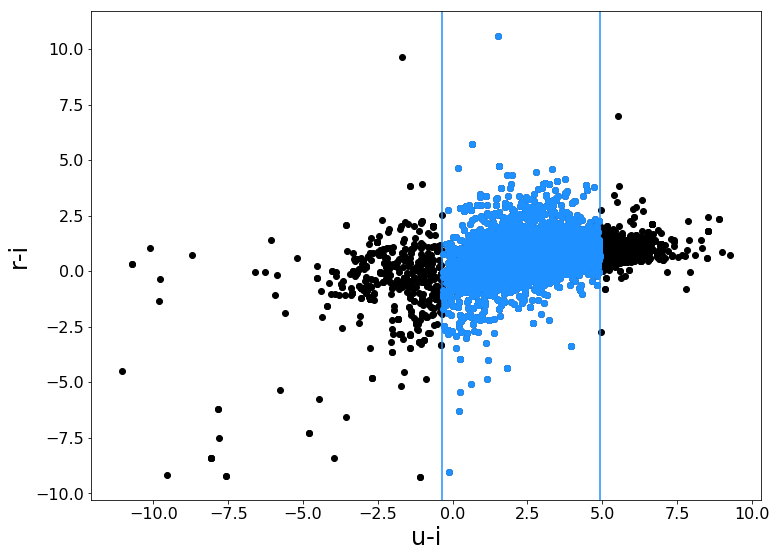

In [39]:
figure(figsize=(12,9))
xticks(fontsize=16)
yticks(fontsize=16)
scatter(survey_table['modelMag_u']-survey_table['modelMag_i'],survey_table['modelMag_r']-survey_table['modelMag_i'], color = 'k')
scatter(full_ui,full_ri,color='dodgerblue')
xlabel('u-i',fontsize=24)
ylabel('r-i',fontsize=24)
axvline(-0.34,color='dodgerblue')
axvline(4.92,color='dodgerblue')
savefig('LSP1.svg',bbox_inches='tight')

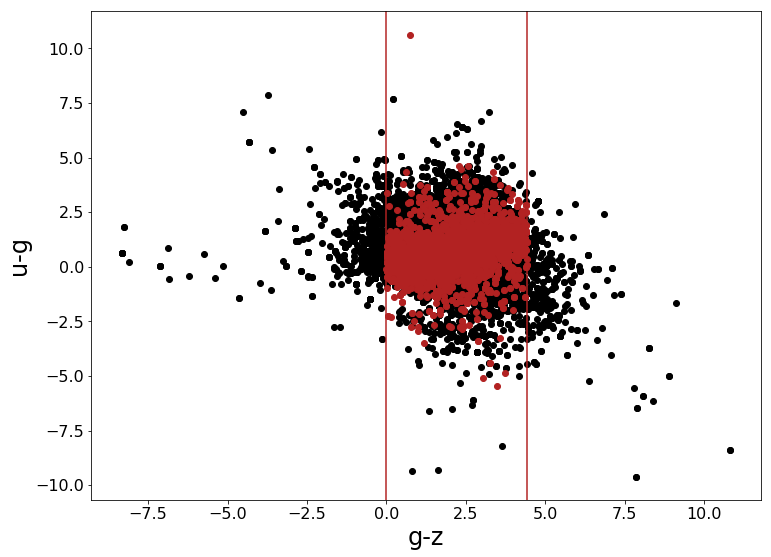

In [40]:
figure(figsize=(12,9))
xticks(fontsize=16)
yticks(fontsize=16)
scatter(survey_table['modelMag_g']-survey_table['modelMag_z'],survey_table['modelMag_u']-survey_table['modelMag_g'], color = 'k')
scatter(full_gz,full_rigz,color='firebrick')
xlabel('g-z',fontsize=24)
ylabel('u-g',fontsize=24)
axvline(0,color='firebrick')
axvline(4.42,color='firebrick')
savefig('LSP2.svg',bbox_inches='tight')

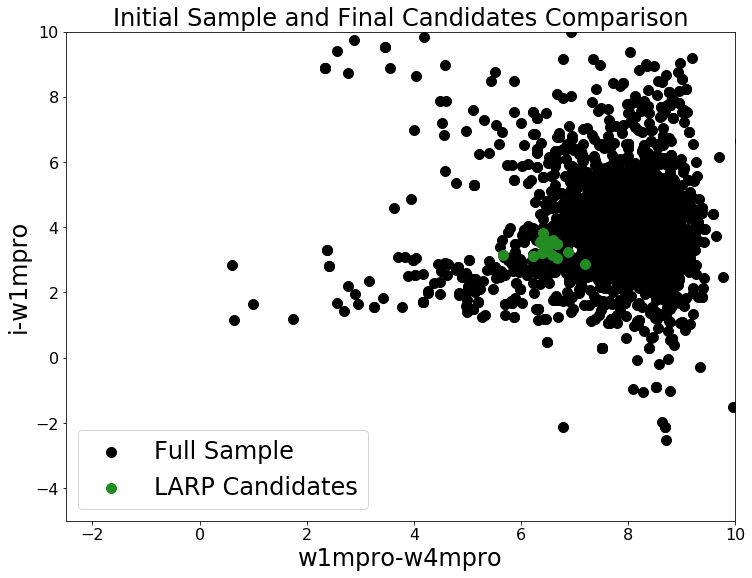

In [41]:
figure(figsize=(12,9))
xticks(fontsize=16)
yticks(fontsize=16)
scatter(survey_table['w1mpro']-survey_table['w4mpro'],survey_table['modelMag_i']-survey_table['w1mpro'], color = 'k', label='Full Sample',s=100)
scatter(prelim_larps['w1mpro']-prelim_larps['w4mpro'],prelim_larps['modelMag_i']-prelim_larps['w1mpro'],color='forestgreen',label='LARP Candidates',s=100)
xlabel('w1mpro-w4mpro',fontsize=24)
ylabel('i-w1mpro',fontsize=24)
xlim(-2.5,10)
ylim(-5,10)
title('Initial Sample and Final Candidates Comparison',fontsize=24)
legend(fontsize=24)
savefig('LSPFinal.svg',bbox_inches='tight')

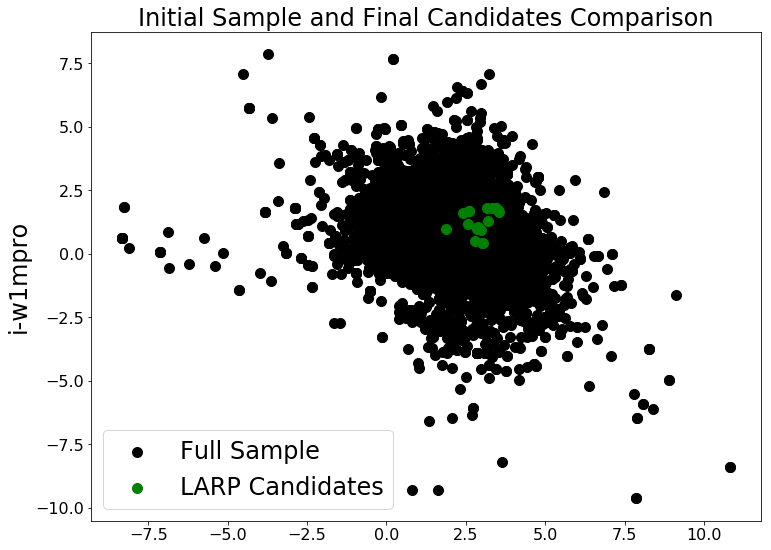

In [46]:
figure(figsize=(12,9))
xticks(fontsize=16)
yticks(fontsize=16)
scatter(sdss_table['modelMag_g']-sdss_table['modelMag_z'],sdss_table['modelMag_u']-sdss_table['modelMag_g'], color = 'k', label = 'Full Sample',s=100)
scatter(prelim_larps['modelMag_g']-prelim_larps['modelMag_z'], prelim_larps['modelMag_u']-prelim_larps['modelMag_g'], color = 'g', label = 'LARP Candidates',s=100)
ylabel('i-w1mpro',fontsize=24)
#xlim(-2.5,10)
#ylim(-5,10)
title('Initial Sample and Final Candidates Comparison',fontsize=24)
legend(fontsize=24)
savefig('LSPFinal.svg',bbox_inches='tight')

In [ ]:
indices